# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.metrics import f1_score
import torch
from textaugment import EDA
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModelForMaskedLM
from itertools import chain
from collections import Counter
import random
import nltk
from gensim import models
from gensim.models import KeyedVectors
from tqdm import tqdm
from scipy import stats
import scikit_posthocs as sp

2023-05-30 15:55:52.319413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 15:55:52.966254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
np.random.seed(42)

def saveplot(title, folder="figures"):
    plt.savefig(os.path.join(folder, title + ".pdf"), bbox_inches="tight")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nikolai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nikolai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Dataset

In [3]:
DATA_PATH = "data"

def load_data(path=DATA_PATH):
    def get_path(set_type, is_args):
        return os.path.join(DATA_PATH, set_type, ("arguments" if is_args else "labels") + "-" + set_type + ".tsv")
    
    data = {}
    
    for set_type in ["test", "training", "validation"]:
        args = pd.read_csv(get_path(set_type, True), sep="\t")
        
        labels = pd.read_csv(get_path(set_type, False), sep="\t")
        labels = labels.drop("Argument ID", axis=1)
        args["Labels"] = [x for x in labels.to_numpy()]
        
        data[set_type] = args
        print(f"Set:{set_type.title()} - Size:{args.shape[0]}")
        
    classes = list(labels.columns)
    
    return data, classes

data, classes = load_data()
data["training"].head()

Set:Test - Size:1576
Set:Training - Size:5393
Set:Validation - Size:1896


,Argument ID,Conclusion,Stance,Premise,Labels
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


# Augmentation

Training size: (5393, 5)
Training augmented size: (6076, 5)


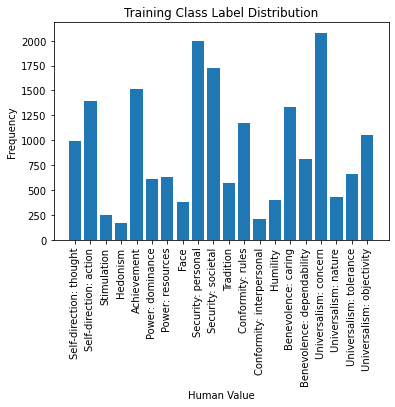

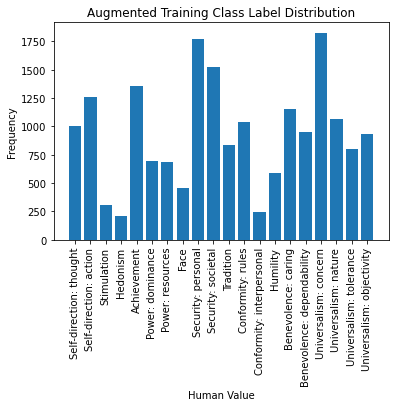

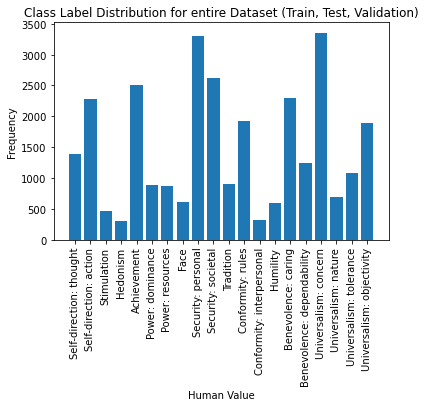

In [4]:
def fix_class_imbalance(data, eda=False):
    russian_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_ru_augm.npy'))
    german_aug = np.load(os.path.join(DATA_PATH, 'train_aug', 'back_trans_de_augm.npy'))

    data_counts = data["training"]['Labels'].sum(axis=0)
    mean_freq = np.mean(data_counts)
    min_classes = np.where(data_counts < mean_freq)[0]
    max_classes = np.where(data_counts >= mean_freq)[0]
    
    data["training_aug"] = data["training"].copy()

    rows_to_remove = []
    rows_to_add = []
    
    for row_idx, row_labels in enumerate(data["training"]['Labels']):

        if not np.intersect1d( np.where(row_labels==1), max_classes).any():
            premise = data["training"].iloc[row_idx]["Premise"]
            if premise.lower() != russian_aug[row_idx].lower():
                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = russian_aug[row_idx]
                rows_to_add.append(new_row)
            
            if premise.lower() != german_aug[row_idx].lower() and german_aug[row_idx].lower() != new_row["Premise"].lower():
                new_row = data["training"].iloc[row_idx].copy()
                new_row["Premise"] = german_aug[row_idx]
                rows_to_add.append(new_row)
            
            if eda:
                eda = EDA()
                prem_size = len(premise)
                aug_premises = [eda.synonym_replacement(premise, int(prem_size*0.3)), 
                                eda.random_swap(premise,int(prem_size*0.2)),
                                eda.random_insertion(premise, int(prem_size*0.1)),
                                eda.random_deletion(premise, p=0.2)]
                for aug_prem in aug_premises:
                    new_row = data["training"].iloc[row_idx].copy()
                    new_row["Premise"] = aug_prem
                    rows_to_add.append(new_row)
        elif not np.intersect1d( np.where(row_labels==1), min_classes).any():
            rows_to_remove.append(row_idx)

    rows_to_remove = random.sample(rows_to_remove, int(len(rows_to_remove)*0.3))
    data["training_aug"] = data["training_aug"].drop(data["training_aug"].index[rows_to_remove])

    data["training_aug"] = pd.concat([pd.DataFrame(rows_to_add), data["training_aug"]]).reset_index(drop=True)


fix_class_imbalance(data, eda=True)
print("Training size:", data["training"].shape)
print("Training augmented size:", data["training_aug"].shape)

plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 12})

data_counts_new = data["training"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Training Class Label Distribution")
plt.show()

data_counts_new = data["training_aug"]['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Augmented Training Class Label Distribution")
plt.show()

all_data = pd.concat([data["training"], data["test"], data["validation"]])
data_counts_new = all_data['Labels'].sum(axis=0)
plt.bar(classes, data_counts_new)
plt.xlabel("Human Value")
plt.xticks(rotation='vertical')
plt.ylabel("Frequency")
plt.title("Class Label Distribution for entire Dataset (Train, Test, Validation)")
saveplot("class_dist_all_data")
plt.show()

# Models

In [5]:
## Code adapted from https://github.com/webis-de/acl22-identifying-the-human-values-behind-arguments/blob/main/src/python/training.py

def f1_score_per_label(y_pred, y_true, value_classes, thresh=0.5, sigmoid=True):
    """Compute label-wise and averaged F1-scores"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    y_true = y_true.bool().numpy()
    y_pred = (y_pred > thresh).numpy()

    f1_scores = {}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 2)

    return f1_scores


class MultiLabelTrainer(Trainer):
    """
        A transformers `Trainer` with custom loss computation

        Methods
        -------
        compute_loss(model, inputs, return_outputs=False):
            Overrides loss computation from Trainer class
        """
    def compute_loss(self, model, inputs, return_outputs=False):
        """Custom loss computation"""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss

In [6]:
def test(data, classes, model_name, tok_name):
    model_eval = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes)) # tok_name was model_name before but that didn't run for me
    tokenizer_eval = AutoTokenizer.from_pretrained(tok_name)
    trainer_eval = MultiLabelTrainer(model_eval, tokenizer=tokenizer_eval)

    def encode(str_input):
        return tokenizer_eval(str_input, truncation=True)

    eval_data = data["Premise"].map(encode)

    pred = trainer_eval.predict(eval_data).predictions
    
    true = np.array([x for x in data["Labels"]])
    f1_scores = f1_score_per_label(pred, true, classes)
    print(f1_scores)
    
    return f1_scores 

f1_scores_distilbert = test(data["validation"], classes, "nikolai40/human-values-distilbert", "distilbert-base-uncased")
f1_scores_roberta = test(data["validation"], classes, "nikolai40/human-values-roberta", "roberta-base")
f1_scores_roberta_aug = test(data["validation"], classes, "nikolai40/human-values-roberta-aug", "roberta-base")
f1_scores_distilbert_aug = test(data["validation"], classes, "nikolai40/human-values-distilbert-aug", "distilbert-base-uncased")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Self-direction: thought': 0.47, 'Self-direction: action': 0.47, 'Stimulation': 0.18, 'Hedonism': 0.26, 'Achievement': 0.62, 'Power: dominance': 0.25, 'Power: resources': 0.47, 'Face': 0.13, 'Security: personal': 0.72, 'Security: societal': 0.6, 'Tradition': 0.36, 'Conformity: rules': 0.45, 'Conformity: interpersonal': 0.13, 'Humility': 0.05, 'Benevolence: caring': 0.56, 'Benevolence: dependability': 0.2, 'Universalism: concern': 0.62, 'Universalism: nature': 0.6, 'Universalism: tolerance': 0.14, 'Universalism: objectivity': 0.46, 'avg-f1-score': 0.39}


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Self-direction: thought': 0.49, 'Self-direction: action': 0.56, 'Stimulation': 0.21, 'Hedonism': 0.41, 'Achievement': 0.65, 'Power: dominance': 0.3, 'Power: resources': 0.44, 'Face': 0.16, 'Security: personal': 0.72, 'Security: societal': 0.63, 'Tradition': 0.45, 'Conformity: rules': 0.52, 'Conformity: interpersonal': 0.18, 'Humility': 0.1, 'Benevolence: caring': 0.58, 'Benevolence: dependability': 0.29, 'Universalism: concern': 0.66, 'Universalism: nature': 0.69, 'Universalism: tolerance': 0.2, 'Universalism: objectivity': 0.44, 'avg-f1-score': 0.43}


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Self-direction: thought': 0.5, 'Self-direction: action': 0.58, 'Stimulation': 0.25, 'Hedonism': 0.39, 'Achievement': 0.64, 'Power: dominance': 0.32, 'Power: resources': 0.47, 'Face': 0.3, 'Security: personal': 0.72, 'Security: societal': 0.64, 'Tradition': 0.44, 'Conformity: rules': 0.48, 'Conformity: interpersonal': 0.23, 'Humility': 0.19, 'Benevolence: caring': 0.57, 'Benevolence: dependability': 0.32, 'Universalism: concern': 0.66, 'Universalism: nature': 0.74, 'Universalism: tolerance': 0.25, 'Universalism: objectivity': 0.47, 'avg-f1-score': 0.46}


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Self-direction: thought': 0.5, 'Self-direction: action': 0.53, 'Stimulation': 0.21, 'Hedonism': 0.37, 'Achievement': 0.64, 'Power: dominance': 0.3, 'Power: resources': 0.45, 'Face': 0.11, 'Security: personal': 0.7, 'Security: societal': 0.59, 'Tradition': 0.36, 'Conformity: rules': 0.45, 'Conformity: interpersonal': 0.13, 'Humility': 0.11, 'Benevolence: caring': 0.58, 'Benevolence: dependability': 0.25, 'Universalism: concern': 0.62, 'Universalism: nature': 0.61, 'Universalism: tolerance': 0.19, 'Universalism: objectivity': 0.46, 'avg-f1-score': 0.41}


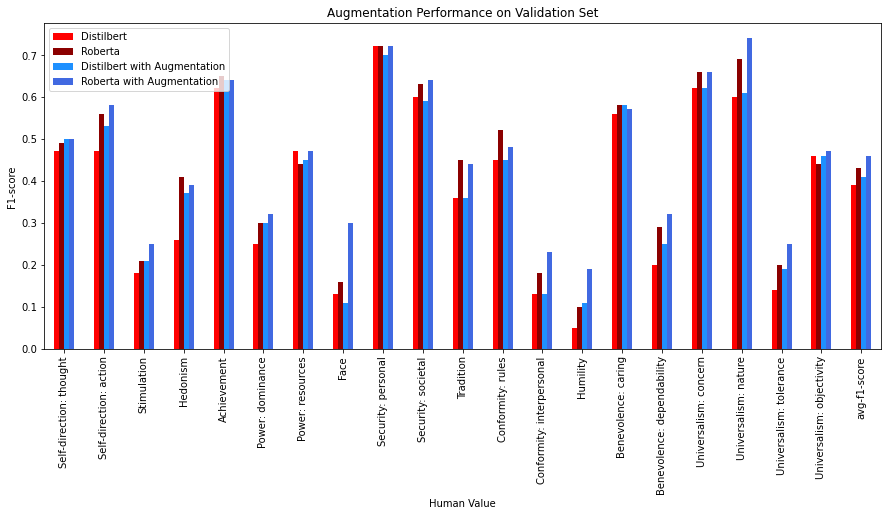

In [7]:
df = pd.DataFrame({"Human Value": f1_scores_distilbert.keys(),
                   "Distilbert": f1_scores_distilbert.values(),
                   "Roberta": f1_scores_roberta.values(),
                   "Distilbert with Augmentation": f1_scores_distilbert_aug.values(),
                   "Roberta with Augmentation": f1_scores_roberta_aug.values()})

df.head()
plt.rcParams["figure.figsize"] = (15,6)
my_colors = ["red", "darkred", "dodgerblue", "royalblue"]
df.plot(x="Human Value", y=["Distilbert", "Roberta", "Distilbert with Augmentation", "Roberta with Augmentation"], kind="bar", color=my_colors)
plt.title("Augmentation Performance on Validation Set")
plt.ylabel("F1-score")
plt.legend()
saveplot("augmentation")
plt.show()

# MLM model

In [8]:
def labels_to_text(labels_string):
    return [label_values_single[i] for i in range(len(label_values_single)) if labels_string[i] == 1]

def create_argument_1(row):
    conclusion = row['Conclusion'].rstrip('.').lower()
    premise = row['Premise'].rstrip('.').lower()
    stance = row['Stance']
    argument = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value {', '.join(row['Labels_text'])} supports this argument."
    argument_with_mask = f"The premise {premise} is {stance} the conclusion that {conclusion}. The human value [MASK] supports this argument."
    return argument, argument_with_mask

def create_argument_2(row):
    premise = row['Premise'].rstrip('.').lower()
    argument = f"The premise {premise} resonates with the human value of {', '.join(row['Labels_text'])}."
    argument_with_mask = f"The premise {premise} resonates with the human value of [MASK]."
    return argument, argument_with_mask

label_values_single = ["thought", "action", "Stimulation", "Hedonism", "Achievement", "dominance", "resources", "Face", "personal", "societal", "Tradition", "rules", "interpersonal", "Humility", "caring", "dependability", "concern", "nature", "tolerance", "objectivity"]

for split in data.keys():
    data[split]['Labels_text'] = data[split]['Labels'].map(lambda x: labels_to_text(x))
    data[split]['Argument_1'], data[split]['Argument_1_mask'] = zip(*data[split].apply(create_argument_1, axis=1))
    data[split]['Argument_2'], data[split]['Argument_2_mask'] = zip(*data[split].apply(create_argument_2, axis=1))

data["test"].head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, concern, tolerance]",The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Achievement, concern, tolerance, objectivity]",The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, dependability, concern]",The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Achievement],The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[Achievement, personal, societal, caring, depe...",The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...


In [9]:
print(data["test"]["Argument_1_mask"][0]) # full argument
print(data["test"]["Argument_2_mask"][0]) # only premise

The premise affirmative action helps with employment equity is against the conclusion that we should end affirmative action. The human value [MASK] supports this argument.
The premise affirmative action helps with employment equity resonates with the human value of [MASK].


In [10]:
model_checkpoint = "distilbert-base-uncased"
distilbert_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def get_predictions(column):

    predictions = []

    for text in tqdm(data["test"][column]):

        inputs = distilbert_tokenizer(text, return_tensors="pt")
        token_logits = distilbert_model(**inputs).logits
        # Find the location of [MASK] and extract its logits
        mask_token_index = torch.where(inputs["input_ids"] == distilbert_tokenizer.mask_token_id)[1]
        mask_token_logits = token_logits[0, mask_token_index, :]
        # Pick the [MASK] candidates with the highest logits
        top_tokens = torch.topk(mask_token_logits, 10, dim=1).indices[0].tolist()

        pred = []
        for token in top_tokens:
            pred.append(distilbert_tokenizer.decode([token]))

        predictions.append(pred)

    return predictions


predictions_1 = get_predictions("Argument_1_mask")
predictions_2 = get_predictions("Argument_2_mask")

100%|███████████████████████████████████████| 1576/1576 [01:21<00:00, 19.30it/s]


# Map prediction to classes using word2vec

In [11]:
word2vec_path = "GoogleNews-vectors-negative300.bin" # get this from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [12]:
def map_words_to_classes(candidate_words, classes, num_classes):
    mappings = []

    for candidate_word in candidate_words:
        similarity_scores = []
        for class_word in classes:
            if candidate_word in model and class_word in model:
                similarity = model.similarity(candidate_word, class_word)
                similarity_scores.append(similarity)

    similarity_scores = np.array(similarity_scores)
    classes = np.array(classes)
    top_indices = np.argsort(similarity_scores)[-num_classes:]
    top_classes = [classes[i] for i in top_indices]
    # print(top_classes)
    mappings.append(top_classes)

    return mappings

labels = list(data["test"]["Labels_text"])

all_mappings_1 = []
for pred, lab in zip(predictions_1, labels):
    word_mappings = map_words_to_classes(pred, label_values_single, len(lab))
    all_mappings_1.append(word_mappings[0])

all_mappings_2 = []
for pred, lab in zip(predictions_2, labels):
    word_mappings = map_words_to_classes(pred, label_values_single, len(lab))
    all_mappings_2.append(word_mappings[0])

In [13]:
data["test"]["Prediction_1"] = all_mappings_1
data["test"]["Prediction_2"] = all_mappings_2
data["test"].head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask,Prediction_1,Prediction_2
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, concern, tolerance]",The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,"[tolerance, societal, resources, rules]","[Humility, dependability, Achievement, dominance]"
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Achievement, concern, tolerance, objectivity]",The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,"[nature, societal, dependability, rules]","[tolerance, societal, Hedonism, interpersonal]"
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, dependability, concern]",The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,"[dependability, concern, tolerance, societal]","[Achievement, thought, personal, caring]"
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Achievement],The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,[societal],[dominance]
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[Achievement, personal, societal, caring, depe...",The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,"[nature, tolerance, societal, resources, rules]","[interpersonal, personal, caring, resources, s..."


In [14]:
def one_hot_encode(words):
    encoding = np.zeros(len(label_values_single), dtype=int)
    for word in words:
        if word in label_values_single:
            encoding[label_values_single.index(word)] = 1
    return encoding

data["test"]['Pred_1_one_hot'] = data["test"]['Prediction_1'].apply(lambda x: one_hot_encode(x))
data["test"]['Pred_2_one_hot'] = data["test"]['Prediction_2'].apply(lambda x: one_hot_encode(x))

data["test"].head()

,Argument ID,Conclusion,Stance,Premise,Labels,Labels_text,Argument_1,Argument_1_mask,Argument_2,Argument_2_mask,Prediction_1,Prediction_2,Pred_1_one_hot,Pred_2_one_hot
0,A26004,We should end affirmative action,against,affirmative action helps with employment equity.,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, concern, tolerance]",The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,The premise affirmative action helps with empl...,"[tolerance, societal, resources, rules]","[Humility, dependability, Achievement, dominance]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,A26010,We should end affirmative action,in favor of,affirmative action can be considered discrimin...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Achievement, concern, tolerance, objectivity]",The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,The premise affirmative action can be consider...,"[nature, societal, dependability, rules]","[tolerance, societal, Hedonism, interpersonal]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
2,A26016,We should ban naturopathy,in favor of,naturopathy is very dangerous for the most vul...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[Achievement, personal, dependability, concern]",The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,The premise naturopathy is very dangerous for ...,"[dependability, concern, tolerance, societal]","[Achievement, thought, personal, caring]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,A26024,We should prohibit women in combat,in favor of,women shouldn't be in combat because they aren...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Achievement],The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,The premise women shouldn't be in combat becau...,[societal],[dominance],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A26026,We should ban naturopathy,in favor of,once eradicated illnesses are returning due to...,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...","[Achievement, personal, societal, caring, depe...",The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,The premise once eradicated illnesses are retu...,"[nature, tolerance, societal, resources, rules]","[interpersonal, personal, caring, resources, s...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, ..."


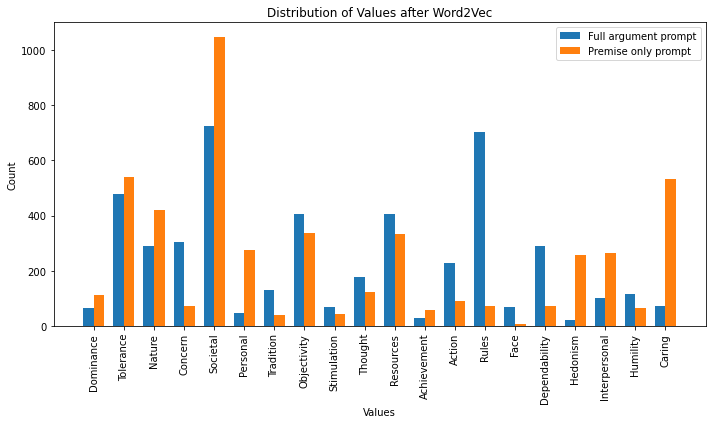

In [15]:
flat_strings1 = [item for sublist in data["test"]['Prediction_1'] for item in sublist]
flat_strings2 = [item for sublist in data["test"]['Prediction_2'] for item in sublist]

string_counts1 = pd.Series(flat_strings1).value_counts()
string_counts2 = pd.Series(flat_strings2).value_counts()

unique_strings = list(set(string_counts1.index) | set(string_counts2.index))

string_counts1 = string_counts1.reindex(unique_strings, fill_value=0)
string_counts2 = string_counts2.reindex(unique_strings, fill_value=0)

x = np.arange(len(unique_strings))

width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, string_counts1, width, label='Full argument prompt')
rects2 = ax.bar(x + width/2, string_counts2, width, label='Premise only prompt')

ax.set_xlabel('Values')
ax.set_ylabel('Count')
ax.set_title('Distribution of Values after Word2Vec')
ax.set_xticks(x)
ax.set_xticklabels([x.title() for x in unique_strings], rotation=90)
ax.legend()

plt.tight_layout()
saveplot("word2vec_dist")
plt.show()

In [16]:
def one_hot_encode(words):
    encoding = np.zeros(len(label_values_single), dtype=int)
    for word in words:
        if word in label_values_single:
            encoding[label_values_single.index(word)] = 1
    return encoding


def test_mlm(data, classes, type=1):

    data[f"Pred_{type}_one_hot"] = data[f'Prediction_{type}'].apply(lambda x: one_hot_encode(x))

    pred = np.array([x for x in data[f"Pred_{type}_one_hot"]]) 
    
    true = np.array([x for x in data["Labels"]])
    f1_scores = f1_score_per_label(pred, true, classes)
    
    return f1_scores


f1_scores_mlm_1 = test_mlm(data["test"], classes, type=1)
f1_scores_mlm_2 = test_mlm(data["test"], classes, type=2)

In [17]:
f1_scores_roberta_aug_test = test(data["test"], classes, "nikolai40/human-values-roberta-aug", "roberta-base")
f1_scores_distilbert_aug_test = test(data["test"], classes, "nikolai40/human-values-distilbert-aug", "distilbert-base-uncased")
bert_website_test = [0.44,0.55,0.05,0.20,0.56,0.29,0.44,0.13,0.74,0.59,0.43,0.47,0.23,0.07,0.46,0.14,0.67,0.71,0.32,0.33, 0.42]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Self-direction: thought': 0.53, 'Self-direction: action': 0.59, 'Stimulation': 0.13, 'Hedonism': 0.24, 'Achievement': 0.57, 'Power: dominance': 0.44, 'Power: resources': 0.48, 'Face': 0.2, 'Security: personal': 0.7, 'Security: societal': 0.6, 'Tradition': 0.57, 'Conformity: rules': 0.44, 'Conformity: interpersonal': 0.34, 'Humility': 0.14, 'Benevolence: caring': 0.51, 'Benevolence: dependability': 0.24, 'Universalism: concern': 0.72, 'Universalism: nature': 0.77, 'Universalism: tolerance': 0.35, 'Universalism: objectivity': 0.4, 'avg-f1-score': 0.45}


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'Self-direction: thought': 0.45, 'Self-direction: action': 0.56, 'Stimulation': 0.08, 'Hedonism': 0.15, 'Achievement': 0.54, 'Power: dominance': 0.29, 'Power: resources': 0.44, 'Face': 0.09, 'Security: personal': 0.71, 'Security: societal': 0.57, 'Tradition': 0.37, 'Conformity: rules': 0.46, 'Conformity: interpersonal': 0.09, 'Humility': 0.12, 'Benevolence: caring': 0.43, 'Benevolence: dependability': 0.25, 'Universalism: concern': 0.67, 'Universalism: nature': 0.72, 'Universalism: tolerance': 0.31, 'Universalism: objectivity': 0.44, 'avg-f1-score': 0.39}


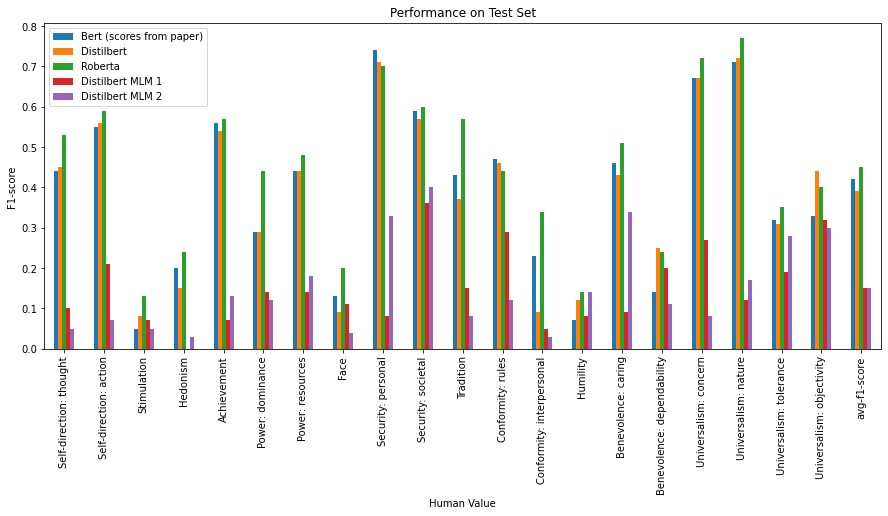

In [18]:
df = pd.DataFrame({"Human Value": f1_scores_distilbert_aug_test.keys(),
                   "Bert (scores from paper)": bert_website_test, 
                   "Distilbert": f1_scores_distilbert_aug_test.values(),
                   "Roberta": f1_scores_roberta_aug_test.values(),
                   "Distilbert MLM 1": f1_scores_mlm_1.values(),
                   "Distilbert MLM 2": f1_scores_mlm_2.values()})

df.head()
plt.rcParams["figure.figsize"] = (15,6)
df.plot(x="Human Value", y=["Bert (scores from paper)", "Distilbert", "Roberta", "Distilbert MLM 1", "Distilbert MLM 2"], kind="bar")
plt.title("Performance on Test Set")
plt.ylabel("F1-score")
saveplot("final_results")
plt.show()

In [19]:
groups_1 = [bert_website_test, f1_scores_distilbert.values(), f1_scores_roberta.values(), f1_scores_mlm_1.values(), f1_scores_mlm_2.values()]
groups_1 = [list(x) for x in groups_1]

groups_2 = [bert_website_test, f1_scores_distilbert.values(), f1_scores_roberta.values()]
groups_2 = [list(x) for x in groups_2]

print(stats.kruskal(*groups_1))
print("\n", sp.posthoc_dunn(groups_1, p_adjust="bonferroni"), "\n")

print(stats.kruskal(*groups_2)) # without mask models

KruskalResult(statistic=39.776235480446374, pvalue=4.8150357592114824e-08)

           1         2         3         4         5
1  1.000000  1.000000  1.000000  0.002290  0.001113
2  1.000000  1.000000  1.000000  0.001837  0.000884
3  1.000000  1.000000  1.000000  0.000102  0.000044
4  0.002290  0.001837  0.000102  1.000000  1.000000
5  0.001113  0.000884  0.000044  1.000000  1.000000 

KruskalResult(statistic=0.6360578540194994, pvalue=0.727581741346057)
